# 차선인식

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Lane Finding (white lane)

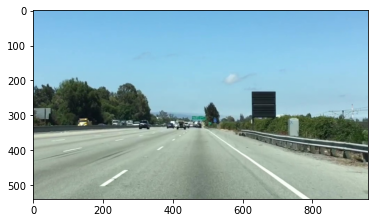

In [2]:
image = mpimg.imread('./data/test.jpg') # RGB
plt.imshow(image)

## Color Selection 

Color Picker Tool로 해당 이미지 색상의 RGB 코드값 얻어오기
https://annystudio.com/software/colorpicker/#download

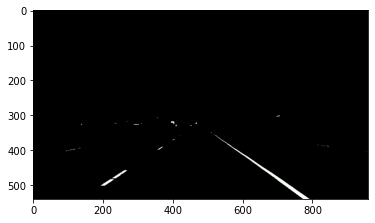

In [4]:
color_select = np.copy(image)

red_threshold = 230
green_threshold = 230
blue_threshold = 230

color_threshold = ((image[:, :, 0] < red_threshold) |
                  (image[:, :, 1] < green_threshold) |
                  (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]
plt.imshow(color_select)

## Region Selection

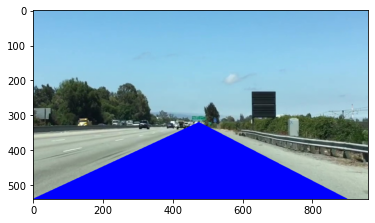

In [5]:
region_select = np.copy(image)

# todo
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

pts = np.array([left_bottom, right_bottom, apex])
cv2.fillPoly(region_select, [pts], color=[0, 0, 255])
plt.imshow(region_select)


## Color and Region Selection

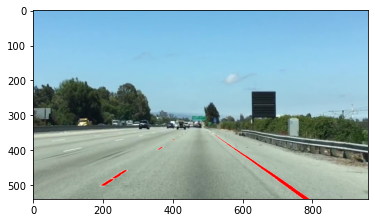

In [19]:
# 1. Color Selection
color_select = np.copy(image)

red_threshold = 230
green_threshold = 230
blue_threshold = 230

color_threshold = ((image[:, :, 0] < red_threshold) |
                  (image[:, :, 1] < green_threshold) |
                  (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]


# 2. Region Selection
region_select = np.copy(image)

# todo
left_bottom = [0, 539]
right_bottom = [900, 539]
apex = [475, 320]

pts = np.array([left_bottom, right_bottom, apex])
cv2.fillPoly(region_select, [pts], color=[0, 0, 255])

region_threshold = ((region_select[:, :, 0] == 0) &  # R channel
                   (region_select[:, :, 1] == 0) &  # G channel
                   (region_select[:, :, 2] == 255))  # B channel


# 3. Color Section + Region Selection
# color_thresholds : 차선(흰색)이 아닌 부분 True 설정
# region_threshold : 관심영역(region of interes, roi)에만 True 설정
lane_select = np.copy(image)
lane_select[~color_threshold & region_threshold] = [255, 0, 0]
    
plt.imshow(lane_select)    

## 2. Lane Finding (white and yello lane)

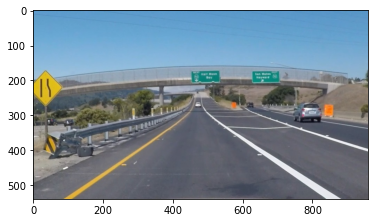

In [26]:
image = mpimg.imread('./data/exit-ramp.jpg') #RGB
plt.imshow(image)

### step 1 : gray scale 변환

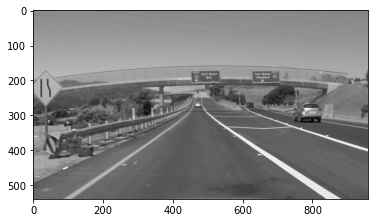

In [28]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

### step 2 : gaussian blurring(option)

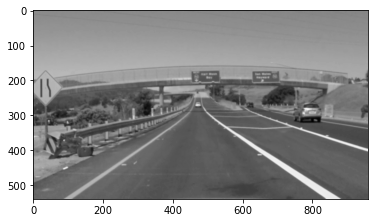

In [31]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='gray')

### step 3 : edge detect 

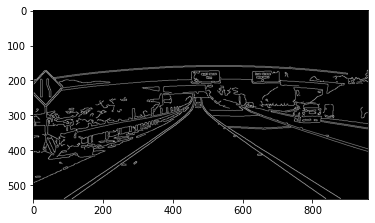

In [32]:
low_threshold = 50
high_threshold = 150 # low:high의 비율 1:2 or 1:3
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

### step 4 : roi selection

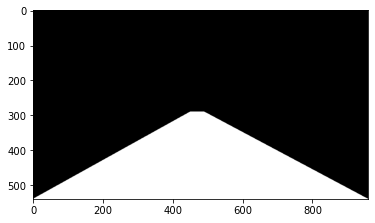

In [40]:
# 관심영역의 mask 준비
height = edges.shape[0]
width = edges.shape[1]
pts = np.array([[0, height-1], [450, 290], [490, 290], [width-1, height-1]])
mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], 255)
plt.imshow(mask, cmap="gray")

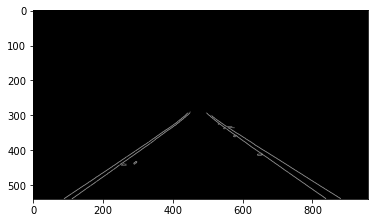

In [41]:
# 위에서 준비한 mask와 edges를 bitwise_and
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='gray')

### step 5: line detect (with hough transform)

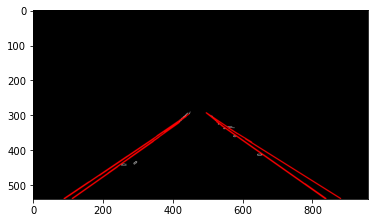

In [57]:
rho = 1 # 1 or 2 : 숫자가 작을수록 더 정밀하게 검출하지만 연산시간이 더 걸림
theta = np.pi/180 # 라디안 단위
threshold = 30 # 축적배열의 숫자가 높다는 것은 직선을 이루는 점들이 많다는 뜻.
                 # 얼마나 큰 값을 직선으로 판단할지는 threshold에 달려있음
minLineLength = 40 # 검출할 선분의 최소길이
maxLineGap = 20 # 직선으로 간주할 최대 에지 점 간격

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold,
                        minLineLength = minLineLength,
                        maxLineGap = maxLineGap)

# (참고) 1차원 데이터를 3차원으로 확장하는 방법
# dst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR) # 직선을 그릴 도화지 (3 채널 도화지)
# dst = cv2.merge([masked_edges, masked_edges, masked_edges])
dst = np.dstack((masked_edges, masked_edges, masked_edges)) # 라인을 그릴 도화지는 3 채널로 준비

if lines is not None:
    for i in range(len(lines)):
        line = lines[i][0]
        pt1 = line[0], line[1]
        pt2 = line[2], line[3]
        cv2.line(dst, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)
plt.imshow(dst)

## Pipeline (step1 ~ step 5)
- Canny Detection -> ROI Selection -> Hough Transform

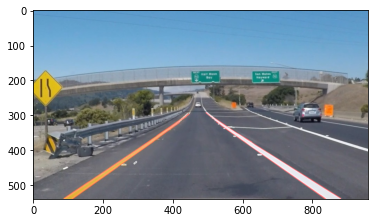

In [65]:
### step 1 : gray scale 변환
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

### step 2 : gaussian blurring(option)
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

### step 3 : edge detect 
low_threshold = 50
high_threshold = 150 # low:high의 비율 1:2 or 1:3
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

### step 4 : roi selection
# 관심영역의 mask 준비
height = edges.shape[0]
width = edges.shape[1]
pts = np.array([[0, height-1], [450, 290], [490, 290], [width-1, height-1]])
mask = np.zeros(edges.shape, edges.dtype)
cv2.fillPoly(mask, [pts], 255)

# 위에서 준비한 mask와 edges를 bitwise_and
masked_edges = cv2.bitwise_and(edges, mask)


### step 5: line detect (with hough transform)
rho = 1 # 1 or 2 : 숫자가 작을수록 더 정밀하게 검출하지만 연산시간이 더 걸림
theta = np.pi/180 # 라디안 단위
threshold = 30 # 축적배열의 숫자가 높다는 것은 직선을 이루는 점들이 많다는 뜻.
                 # 얼마나 큰 값을 직선으로 판단할지는 threshold에 달려있음
minLineLength = 40 # 검출할 선분의 최소길이
maxLineGap = 20 # 직선으로 간주할 최대 에지 점 간격

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold,
                        minLineLength = minLineLength,
                        maxLineGap = maxLineGap)

# (참고) 1차원 데이터를 3차원으로 확장하는 방법
# dst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR) # 직선을 그릴 도화지 (3 채널 도화지)
# dst = cv2.merge([masked_edges, masked_edges, masked_edges])
dst = np.dstack((masked_edges, masked_edges, masked_edges)) # 라인을 그릴 도화지는 3 채널로 준비

if lines is not None:
    for i in range(len(lines)):
        line = lines[i][0]
        pt1 = line[0], line[1]
        pt2 = line[2], line[3]
        cv2.line(dst, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

#result = cv2.add(image, dst)
result = cv2.addWeighted(image, 1.0, dst, 0.8, 0)

plt.imshow(result)